## Properties of the sounds that are getting generated in the task

In [15]:
import pandas as pd
from sound_functions import generate_tone_matrix, cloud_of_tones_matrices, sound_matrix_to_sound
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.signal import spectrogram
from lecilab_behavior_analysis.utils import get_sound_stats
# refresh them if I run this again
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
lowest_freq = 5000
highest_freq = 40000
freqs_log_spaced = np.round(np.logspace(np.log10(lowest_freq), np.log10(highest_freq), 18)).tolist()
low_freqs = freqs_log_spaced[:6]
high_freqs = freqs_log_spaced[-6:]
# Define sound properties
sound_properties_for_cot_mat = {
    "duration": .5,
    "high_amplitude_mean": 70,
    "low_amplitude_mean": 70,
    "amplitude_std": 2,
    "high_freq_list": high_freqs,
    "low_freq_list": low_freqs,
    "subduration": 0.03,
    "suboverlap": 0.01,
}
sound_properties_for_sound_making = {
    "sample_rate": 192000,
    "ramp_time": 0.005,
    "subduration": 0.03,
    "suboverlap": 0.01,
}
# fix the random seed
np.random.seed(0)

In [33]:
# Generate the two component matrices for the cloud of tones
high_mat, low_mat = cloud_of_tones_matrices(
    **sound_properties_for_cot_mat,
    high_prob=.7,
    low_prob=.3)

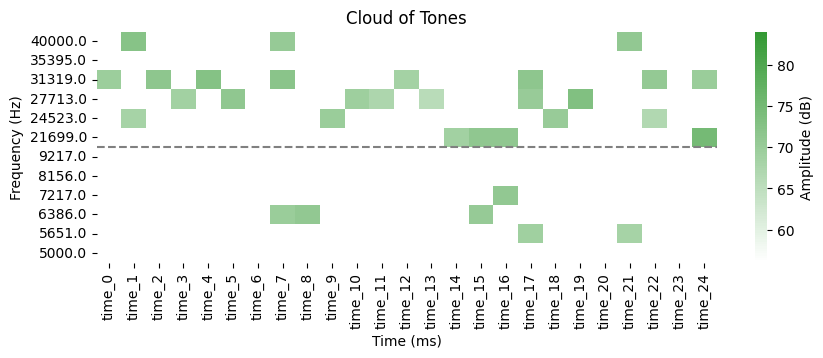

In [34]:
# plot a heatmap of the cloud of tones
# Create a custom colormap that is white when the value is 0
colors = [(1, 1, 1), (0.2, 0.6, 0.2)]  # White to seagreen
n_bins = 100  # Discretize the interpolation into bins
cmap_name = 'white_to_seagreen'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
plt.figure(figsize=(10, 3))
mat_to_plot = pd.concat([high_mat[::-1], low_mat[::-1]])
sns.heatmap(mat_to_plot,
            cmap=cmap,
            vmin=sound_properties_for_cot_mat["low_amplitude_mean"] * .8,
            vmax=sound_properties_for_cot_mat["high_amplitude_mean"] * 1.2,
            cbar_kws={'label': 'Amplitude (dB)'})
plt.hlines(6, 0, high_mat.shape[1], colors='gray', linestyles='dashed')
plt.xlabel("Time (ms)")
plt.ylabel("Frequency (Hz)")
plt.title("Cloud of Tones")
plt.show()

In [ ]:
# Fake calibrate by transforming all values of the array to be 1 on the low mat
low_mat_calibrated = low_mat.map(
    lambda x: 1 if x > 0 else 0
)
# high mat to 0.1
high_mat_calibrated = high_mat.map(
    lambda x: 0.1 if x > 0 else 0
)
# Generate the sound
sound = sound_matrix_to_sound(
    pd.concat([high_mat_calibrated, low_mat_calibrated], axis=0),
    **sound_properties_for_sound_making,
)

/tmp/ipykernel_369630/2524001179.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t, f, 10 * np.log10(Sxx))


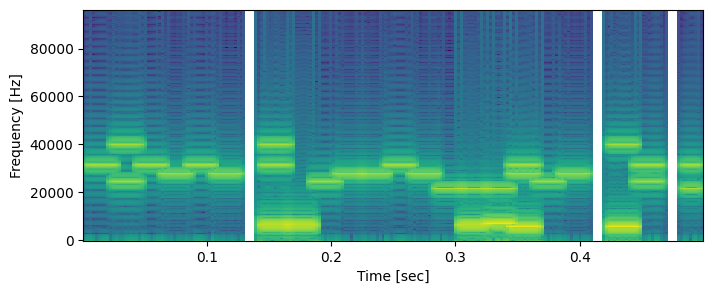

In [36]:
# plot a spectrogram
f, t, Sxx = spectrogram(sound, sound_properties_for_sound_making["sample_rate"], nperseg=512)
plt.figure(figsize=(8, 3))
plt.pcolormesh(t, f, 10 * np.log10(Sxx))
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [sec]")
plt.show()

In [13]:
sound_matrices ={"high_tones": high_mat, "low_tones": low_mat}
get_sound_stats(sound_matrices)

{'high_tones': {'number_of_tones': 31,
  'total_percentage_of_tones': 0.20666666666666667,
  'percentage_of_timebins_with_evidence': 0.92},
 'low_tones': {'number_of_tones': 5,
  'total_percentage_of_tones': 0.03333333333333333,
  'percentage_of_timebins_with_evidence': 0.2},
 'total_evidence_strength': 0.7222222222222222}

Explore the statistics of the generated matrices

In [14]:
time_bins = 25
probs_to_test = np.linspace(.1, .9, 6)
n_times = 10000

In [15]:
list_of_dicts = []
# reduce the decimal points
probs_to_test = np.round(probs_to_test, 2)
for prob in probs_to_test:
    for i in range(n_times):
        matrix, _ = generate_tone_matrix(high_freqs, time_bins, prob)
        # calculate the number of 1s
        evidences = np.sum(matrix.values)
        # calculate the percentage of 1s
        perc = evidences / matrix.size
        # calculate the real probability
        # of having at least one 1 in each column
        colsums = matrix.sum(axis=0)
        real_prob = np.sum(colsums > 0) / len(colsums)
        list_of_dicts.append(
            {"prob": prob,
             "evid": evidences,
             "perc": perc,
             "real_prob": real_prob,
             }
        )

df = pd.DataFrame(list_of_dicts)

Find for each probability, the total amount of filled spaces of the matrix

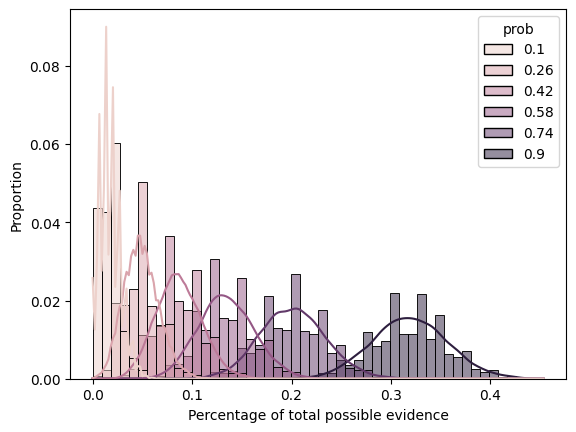

In [40]:
sns.histplot(data=df, x="perc", hue="prob", bins=50, kde=True, stat="proportion")
plt.xlabel("Percentage of total possible evidence")
plt.show()

Chech the real distributions of the probabilities of having a tone (or more) in each time bin

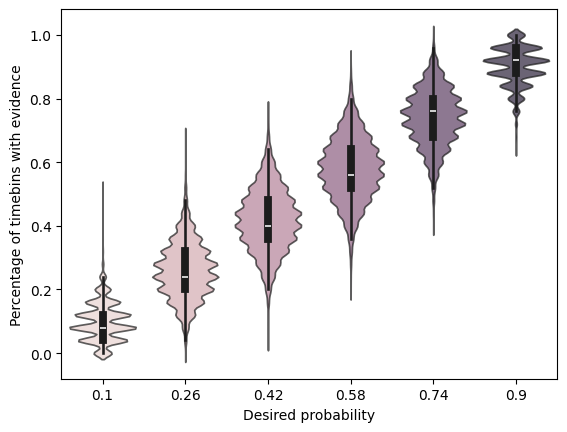

In [43]:
sns.violinplot(data=df, x="prob", y="real_prob", hue="prob", alpha=.7)
plt.ylabel("Percentage of timebins with evidence")
plt.xlabel("Desired probability")
# remove the legend
plt.legend([], [], frameon=False)
plt.show()

Different combination of probabilities will generate different evidences, if we consider the total number of presented tones for one or the other frequency classification (low or high)

In [22]:
def evidence_strength(x, y):
    return (x - y) / (x + y)

In [23]:
# generate another dataset that contains all 
# the possible values of evidence strength
probs_comb = [
    (probs_to_test[0], probs_to_test[-1]),
    (probs_to_test[1], probs_to_test[-2]),
    (probs_to_test[2], probs_to_test[-3]),
]
dicts = []
for prob1, prob2 in probs_comb:
    probs_pair = str(prob1) + "-" + str(prob2)
    for i in range(n_times):
        x = df[df["prob"] == prob1].sample()["evid"].values[0]
        y = df[df["prob"] == prob2].sample()["evid"].values[0]
        dicts.append({"prob": probs_pair, "evid": evidence_strength(x, y)})

evidence_strengths = pd.DataFrame(dicts)

Calculate the percentage of unfair trials

In [48]:
unfair_perc = np.sum(evidence_strengths["evid"] >= 0) / len(evidence_strengths)

Plot the distributions of the real evidence (considering for this total tones), that come out of the different combinations of probabilities

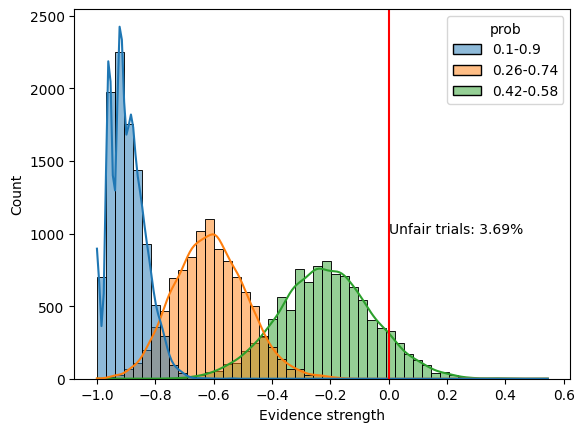

In [49]:
sns.histplot(data=evidence_strengths, x="evid", hue="prob", bins=50, kde=True)
plt.axvline(0, color="red")
plt.text(0, 1000, f"Unfair trials: {100 * unfair_perc:.2f}%")
plt.xlabel("Evidence strength")
plt.show()

In [26]:
# calculate unfairness on the filled columns
dicts = []
for prob1, prob2 in probs_comb:
    probs_pair = str(prob1) + "-" + str(prob2)
    for i in range(n_times):
        x = df[df["prob"] == prob1].sample()["real_prob"].values[0]
        y = df[df["prob"] == prob2].sample()["real_prob"].values[0]
        dicts.append({"prob": probs_pair, "real_prob_diff": x - y})

real_prob_difs_df = pd.DataFrame(dicts)

In [51]:
unfair_perc = np.sum(real_prob_difs_df["real_prob_diff"] >= 0) / len(real_prob_difs_df)

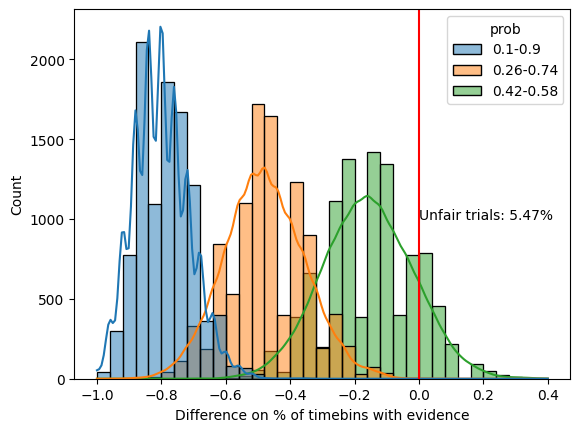

In [53]:
sns.histplot(data=real_prob_difs_df, x="real_prob_diff", hue="prob", bins=35, kde=True)
plt.axvline(0, color="red")
plt.text(0, 1000, f"Unfair trials: {100 * unfair_perc:.2f}%")
plt.xlabel("Difference on % of timebins with evidence")
plt.show()